# An Analysis of IMDb's Top 1000 Films List 

### Aim 
This analysis aims to uncover valuable insights and trends within the world of cinema by examining the top-rated movies according to IMDb's user-generated ratings. 

The following analysis will be performed:
 - A decade by decade analysis, uncovering film trends as they develop over time. 
 - Identifying the top directors within the list, and creating an overall 'score' to identify the top director of the 21st century according to the IMDb list. 
 - Discerning the most prevelant film stars to occur within the list, revealing the influence that the stars have had over the decades. 
 - Genre exploration, identifying the most and least frequent genres to make the list. 
 
 
### Data Collection
The data was sourced from Kaggle user Harshit Shankhdhar, and was last updated in 2020. The dataset was compiled through web scraping the IMDb website. 

The link to the original data can be found below:
https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows/data


### Data Cleaning
The dataset required some basic cleaning. This involved changing column types to numeric values, modifying the "Gross" column to reflect millions of dollars, and dropping NAs where applicable. 




In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import warnings
from os import path
from PIL import Image

# when updating packages remove this: 
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
df_og = pd.read_csv("imdb_top_1000.csv")
column_list = df_og.columns.tolist()


 ## Decade analysis
 
 An analysis was performed on the frequency and popularity of films released across various decades. Firstly a decade column had to be added to the data. A bar chart was then employed to reveal the frequency in which each decade appeared in the list, and boxplots were used to show the average rating of films across the decades. 
 
The charts revealed that the 2000's and the 2010's were by far the most frequent decades to appear in the list. The boxplots suggest that the mean ratings across these decades are roughly comparable. Subsequent analyses are planned to investigate potential statistically significant differences between these means. Given the presence of outliers and non-normal distributions within the groups, future analysis will involve applying transformations or employing non-parametric tests to ensure robust results.

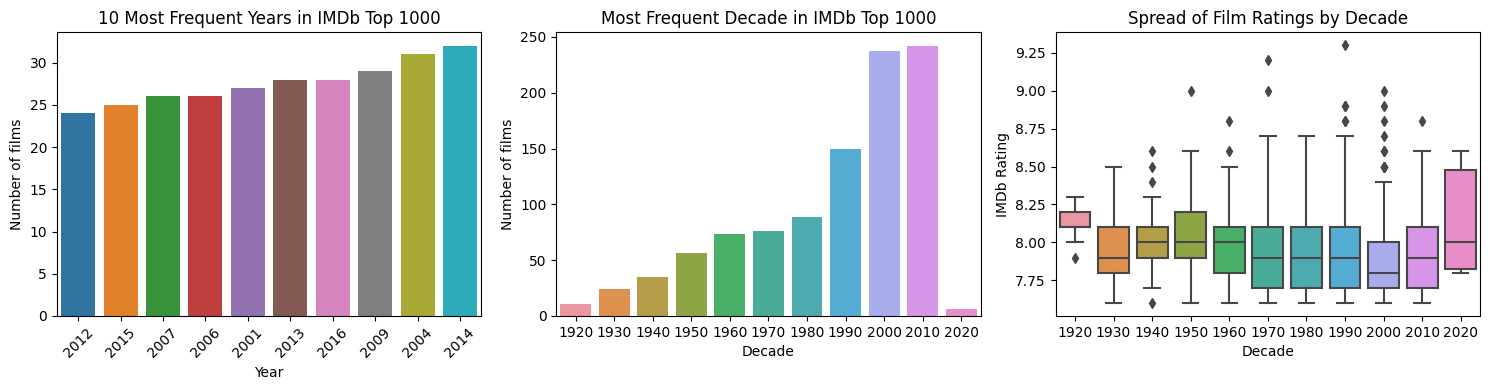

In [150]:
df = df_og[["Series_Title", "Released_Year", "IMDB_Rating", "Director", "Genre", "Runtime", "No_of_Votes", "Gross"]]

# convert Released_Year to numeric, drop NAs, and add decade column 
df_clean = df.copy()
df_clean["Released_Year"] = pd.to_numeric(df_clean["Released_Year"], errors="coerce")
df_clean.dropna(subset=["Released_Year"], inplace = True)
df_clean["Released_Year"] = df_clean["Released_Year"].astype(int)  
df_clean["Decade"] = df_clean["Released_Year"] // 10 * 10

# remove commas from "Gross", drop NAs, convert to integers and convert value to millions
# the NA drop removes quite a few rows so maybe I should create a new df for this, otherwise its gonna change 
# the outcome of the other summaries
df_clean["Gross"] = df_clean["Gross"].str.replace(",", "")
# create new df that contains all release years and their respective counts
year_counts = df_clean["Released_Year"].value_counts().reset_index()
year_counts.columns = ['Year', 'Count']

top_10_years = year_counts.head(10).sort_values(by='Count')
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.barplot(data=top_10_years, x="Year", y="Count", order=top_10_years["Year"], ax=axes[0])
axes[0].set_ylabel("Number of films")
axes[0].set_title("10 Most Frequent Years in IMDb Top 1000")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=df_clean, x="Decade", ax=axes[1])
axes[1].set_ylabel("Number of films")
axes[1].set_title("Most Frequent Decade in IMDb Top 1000")

sns.boxplot(data=df_clean, x="Decade", y="IMDB_Rating", ax=axes[2])
axes[2].set_title("Spread of Film Ratings by Decade")
axes[2].set_ylabel("IMDb Rating")

plt.tight_layout()
plt.show()


## Director analysis

A frequency analysis is utilized to uncover the directors with the highest number of films featured in the IMDb top 1000 list, ultimately identifying Alfred Hitchcock as the director with the most films on the list. To gauge the distribution of IMDb ratings among the five most frequently appearing directors, a boxplot is employed. Interestingly, all five directors exhibit a somewhat similar distribution pattern. To ascertain whether there are statistically significant differences in their mean ratings, an analysis of variance (ANOVA) test is conducted.

Before conducting the **one way ANOVA**, we must first assure the assumptions of the test are met: 

1. The samples are independent
    - All films scores are independent of one another. 
 
 
2. Each group has homogeneity of Variances (Homoscedasticity)
    - Bartlett's Test for homoscedasticity is applied to assess whether there is equal variance among the groups. The test results in a p-value of 0.18, which indicates that there is insufficient evidence to reject the null hypothesis stating that the variances among the groups are equal. 
 
 
3. Each group is normally distributed (or large enough sample size to rely on CLT)
     - The boxplot illustrates that the majority of groups exhibit a normal distribution, albeit with some instances of skewness. To assess whether the assumption of normality holds, QQ plots were employed. These plots indicate some deviation from the ideal straight line, implying a potential departure from normal distribution. However, it is reasonable to attribute this deviation to the small sample size and the inherent randomness associated with it.
     
     
4. There are no signficant outliers. 
     - The boxplot reveals only 1 outlier, and it is not deemed to be significant and therefore does not violate the assumption. 
     

It should also be noted that while ANOVA is fairly robust to small sample sizes, it can negatively impact the power of the test. Therefore the small sample sizes within the groups could negatively impact the tests ability to reject the null hyptohesis given the alternative hypothesis is true. 


#### Results of the one-way ANOVA

 - **Null hypothesis:** the mean rating is equal for all directors
 - **Alternative hyptohesis:** the mean rating is not equal for all directors

The ANOVA test yielded a p-value of 0.38, indicating that there is insufficient evidence to reject the null hypothesis. Thus, we can infer that there is no statistically significant difference among the mean IMDb ratings of the five tested directors.



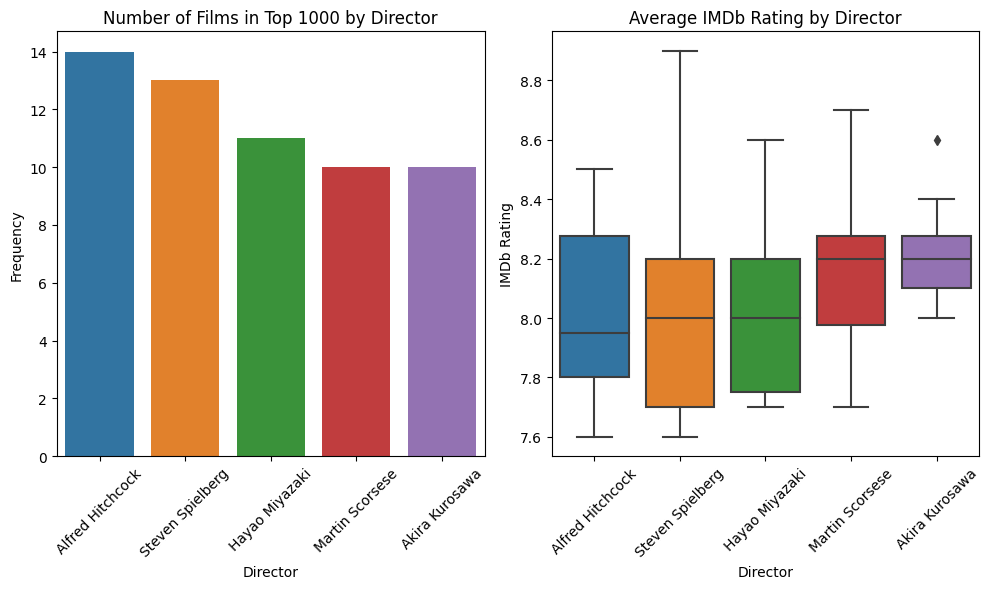

In [151]:
# MODIFY THIS TO SHOW PROPORTIONS ACROSS DECADES FOR EACH DIRECTOR???

# get the 5 directors with the most films in the list
top_directors = df_clean['Director'].value_counts().head(5).index


fig, ax = plt.subplots(1,2, figsize=(10, 6))
# filter df_clean to only contain rows with top_directors and order by the top 5
sns.countplot(data = df_clean[df_clean['Director'].isin(top_directors)], x = "Director", order = top_directors, ax = ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel("Frequency")
ax[0].set_title("Number of Films in Top 1000 by Director")
#max_count = df_clean['Director'].value_counts().max()
#ax[0].set_yticks(np.arange(0, max_count + 1, 2))


sns.boxplot(data = df_clean[df_clean['Director'].isin(top_directors)], x = "Director", y = "IMDB_Rating", order = top_directors, ax = ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel("IMDb Rating")
ax[1].set_title("Average IMDb Rating by Director")

plt.tight_layout()
plt.show()


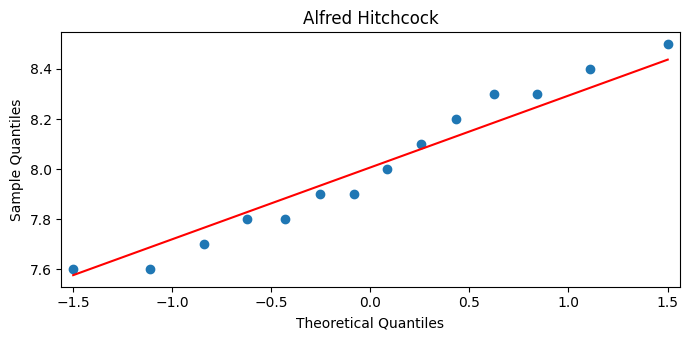

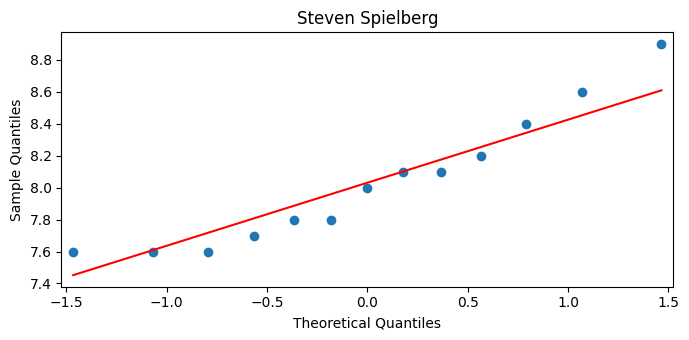

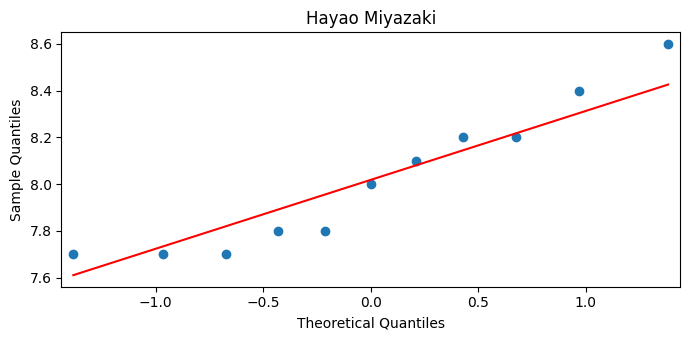

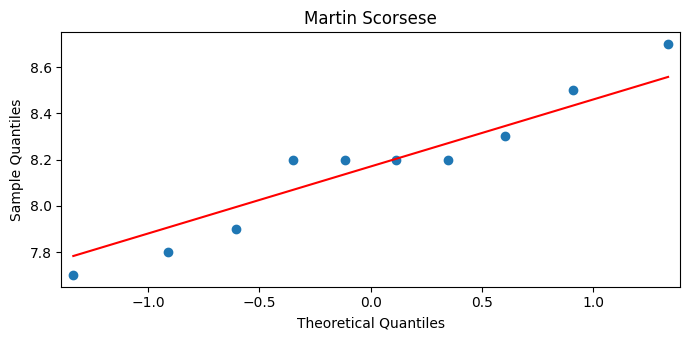

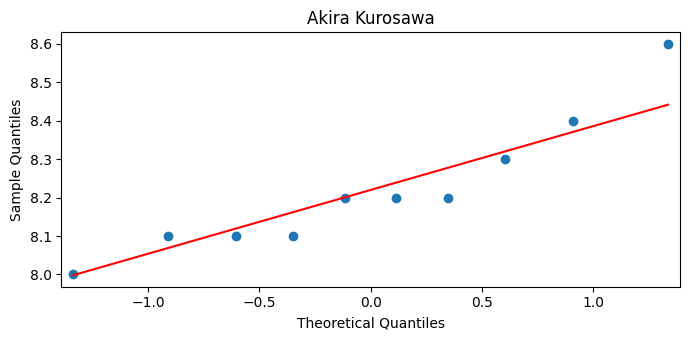

In [152]:
director_ratings_list = []

for director in top_directors:
    director_filt = df_clean['Director'] == director
    director_ratings = df_clean.loc[director_filt, 'IMDB_Rating']
    director_ratings_list.append(director_ratings)
    sm.qqplot(director_ratings, line = 's')
    plt.title(director)
    plt.show()
    


In [153]:
# Perform Bartlett's Test for homoscedasticity
bartlett_statistic, p_value = stats.bartlett(*director_ratings_list)

# Null hyptothesis: all groups have equal variance 
# Alternative hypothesis: there is a significant difference between at least two of the groups variance 

if p_value < 0.05:
    print("Bartlett's test: Variances are not equal (homoscedasticity assumption is violated).")
else:
    print("Bartlett's test: Variances are equal (homoscedasticity assumption holds).")
    
round(p_value, 2)



Bartlett's test: Variances are equal (homoscedasticity assumption holds).


0.18

In [154]:
# All the assumptions hold so perform one-way ANOVA (analysis of variance)

# Null hypothesis: the mean rating is equal for all directors
# Alternative hyptohesis: the mean rating is not equal for all directors

f, p = stats.f_oneway(*director_ratings_list)

p = round(p, 2)
if p > 0.05:
    print(f"P-value: {p} > 0.05, therefore we cannot reject the null. The mean rating is equal for all directors")
else:
    print(f"P-value: {p} < 0.05, therefore we reject the null. The mean rating is NOT equal for all directors")

P-value: 0.38 > 0.05, therefore we cannot reject the null. The mean rating is equal for all directors


## Who is IMDb's top director of the 21st century?


This analysis serves to identify who the 21st centuries top director is, using the IMDb top 1000 data as a metric. Christopher nolan is the director with the most films released in the 21st century to make the top 1000, although deeper analysis is required to come to a final conclusion. All analysis performed will be limited to films within the list that were released in the 21st century. 

My curiosity led me to explore who had the highest average movie rating and the highest average box office earnings among the films in the list. The results unveiled Peter Jackson as the director with the highest average rating and Martin Scorsese as the director with the highest average gross earnings. This discovery highlighted the need for a more generalized scoring system that could provide a definitive ranking, given that different directors excelled in different metrics. I aimed to create a unified ranking score for directors by combining both average movie rating and average box office earnings. To achieve this, I followed a two-step process.

Firstly, I employed MinMax scaling on both features to ensure that the range of each feature wouldn't disproportionately influence the final score.

Secondly, I needed to decide whether to assign different weights to these features. In my perspective, an IMDb rating is a more accurate indicator of a film's quality compared to its earnings since high grossing numbers can often be attributed to extensive marketing efforts rather than film quality. Therefore, I assigned a slightly higher weight of 0.6 to the IMDb rating and a weight of 0.4 to the box office earnings when creating the composite ranking score.
The scores without the adjusted weights revealed Anthony Russo to the be the top director within the list. When applying the weights, Peter Jackson was found to be the top director. 

Due to my initial beliefs that a directors average IMDb rating is a better indicator of a quality director, I will conclude that Peter Jackson is the top director of the 21st century.

The choice of weights in this study represents a significant limitation. Modifying the weight values would substantially impact the results, and these weight selections were not grounded in well-defined domain expertise or knowledge. To establish the most appropriate weight values, further research and investigation would be necessary.







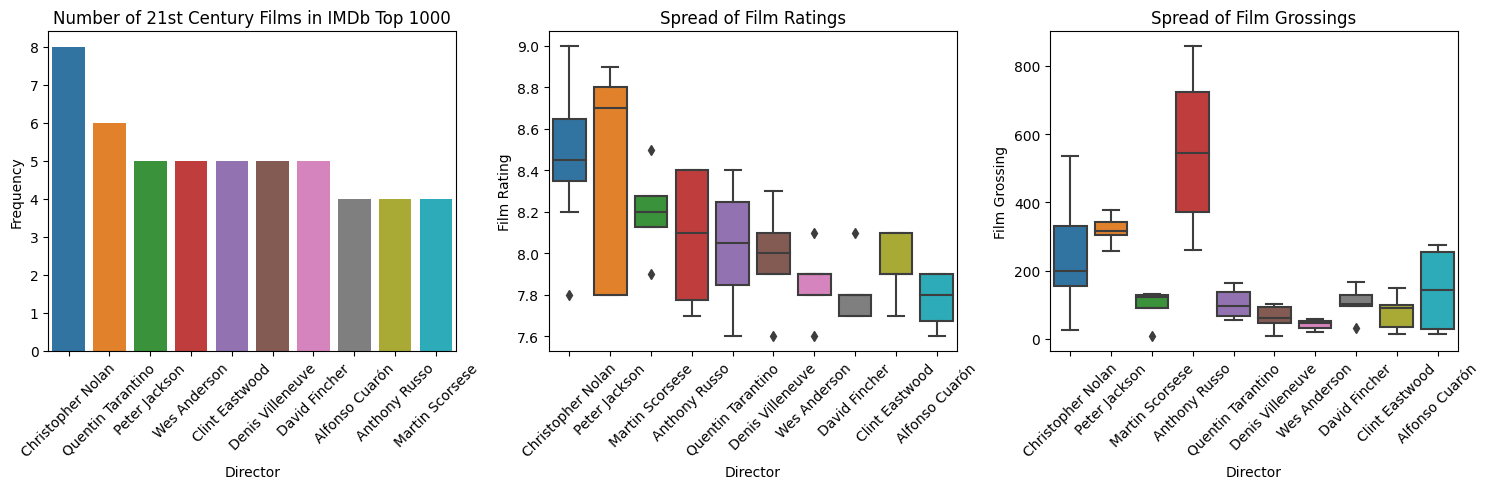

In [155]:

# Cleaning the gross column (drop NA's, convert to int, and convert to # of millions grossed)
df_gross = df_clean.copy()
df_gross.dropna(subset=["Gross"], inplace = True)#
df_gross["Gross"] = df_gross["Gross"].astype(int)
df_gross["Gross"] = df_gross["Gross"] / 1000000

# filter data to only films in the 21st century
gross_condition = (df_gross['Decade'] == 2000) | (df_gross['Decade'] == 2010) | (df_gross['Decade'] == 2020)
df_gross = df_gross[gross_condition]

top_gross = df_gross['Director'].value_counts().head(10).index
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(data = df_gross[df_gross['Director'].isin(top_gross)], x = "Director", order = top_gross, ax = axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title("Number of 21st Century Films in IMDb Top 1000")
axes[0].set_ylabel("Frequency")

sns.boxplot(data = df_gross[df_gross['Director'].isin(top_gross)], x = "Director", y = "IMDB_Rating", ax = axes[1])
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title("Spread of Film Ratings")
axes[1].set_ylabel("Film Rating")

sns.boxplot(data = df_gross[df_gross['Director'].isin(top_gross)], x = "Director", y = "Gross", ax = axes[2])
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_title("Spread of Film Grossings")
axes[2].set_ylabel("Film Grossing")

plt.tight_layout()
plt.show()


In [156]:

# sample sizes are too small for an ANOVA test, so instead we will combine the mean IMDB rating and mean grossing
# into a single "score" and rank them.
director_filt_21 = df_gross[df_gross['Director'].isin(top_gross)]

#print(director_filt_21.groupby('Director')['IMDB_Rating'].mean())
#print(director_filt_21.groupby('Director')['Gross'].mean())


# scale rating and gross features so they can be combined
scaler = MinMaxScaler()
normalized_df = director_filt_21.copy()
normalized_df['Normalized_IMDB_Rating'] = scaler.fit_transform(director_filt_21[['IMDB_Rating']])
normalized_df['Normalized_Gross'] = scaler.fit_transform(director_filt_21[['Gross']])
normalized_df['Overall_Score'] = (normalized_df['Normalized_Gross'] + normalized_df['Normalized_IMDB_Rating']) / 2

# output the directors sorted by the normalized top 'Overall_Score'
without_weights = normalized_df.groupby('Director')['Overall_Score'].mean().sort_values(ascending = False)


weight_rating = 0.6
weight_grossing = 0.4
normalized_df['Weighted_Score'] = (weight_rating * normalized_df['Normalized_IMDB_Rating']) + (weight_grossing * normalized_df['Normalized_Gross'])
with_weights = normalized_df.groupby('Director')['Weighted_Score'].mean().sort_values(ascending = False)

print("Directors ranked without weights: ")
print(without_weights)
print("")

print("Directors ranked with weights: ")

print(with_weights)


Directors ranked without weights: 
Director
Anthony Russo        0.489310
Peter Jackson        0.469272
Christopher Nolan    0.446216
Martin Scorsese      0.266673
Quentin Tarantino    0.211047
Denis Villeneuve     0.167782
Clint Eastwood       0.162994
Alfonso Cuarón       0.142533
David Fincher        0.136533
Wes Anderson         0.113492
Name: Overall_Score, dtype: float64

Directors ranked with weights: 
Director
Peter Jackson        0.489704
Christopher Nolan    0.480187
Anthony Russo        0.459305
Martin Scorsese      0.299053
Quentin Tarantino    0.230742
Denis Villeneuve     0.188511
Clint Eastwood       0.178966
David Fincher        0.140655
Alfonso Cuarón       0.139027
Wes Anderson         0.127936
Name: Weighted_Score, dtype: float64


## Movie star word cloud

This world cloud visualisation represents the prominence of various actors and actresses in the IMDb top 1000, with the size of their names reflecting their relative frequency.

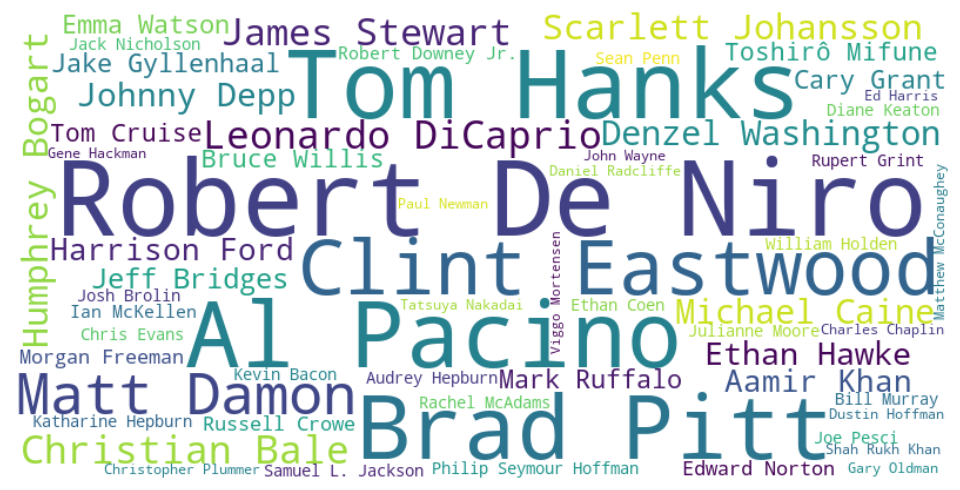

In [157]:
movie_stars = df_og.copy()[['Series_Title', 'Released_Year', 'IMDB_Rating', 'Gross', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']]

# Get moviestar value counts for each column Star1...Star4
star_sums = movie_stars[['Star1', 'Star2', 'Star3', 'Star4']].apply(pd.Series.value_counts)
# Replace NaN with 0 so we can sum them into a total
star_sums[['Star1', 'Star2', 'Star3', 'Star4']] = star_sums[['Star1', 'Star2', 'Star3', 'Star4']].fillna(0)
# Create a total column that contains total number of moviestar occurances across the 4 star columns
star_sums['Total'] = star_sums['Star1'] + star_sums['Star2'] + star_sums['Star3'] + star_sums['Star4']
star_sums = star_sums.sort_values('Total', ascending = False)
star_sums = star_sums.reset_index().rename(columns = {'index':'Actor'})

# turn star frequency df into a dict
star_sums_dict = dict(zip(star_sums['Actor'], star_sums['Total']))

# Generate the word cloud with the word frequencies as weights
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words = 60)
wordcloud.generate_from_frequencies(star_sums_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



## Genre analysis


The analysis reveals the 5 most frequent and the 5 least frequent genres that appear in the IMDB top 1000 film list. It must be noted that the total sum of genre occurences far exceeds 1000, due to individual films being listed with up to 3 genres. 

The chart reveals drama to be by far the most frequent genre to appear in the list, followed by comedy, crime, adventure, and action. The least frequent genres to appear are horror, western, film-noir, sport, and musical. 




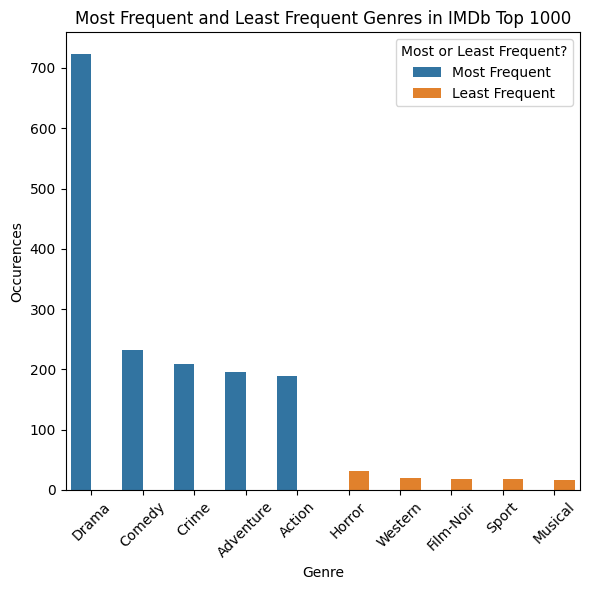

In [158]:
genres = df_clean[['Genre']]
genre_count_dict = {}

with pd.option_context('mode.chained_assignment', None):
    # iterate through the genre column
    for index, row in genres.iterrows():
        # split multiple genres into individual genres
        row = str(row[0]).replace(",", "").split()
        
        # loop through the individual ones and update dictionary counter
        for genre in row:
            if genre not in genre_count_dict:
                genre_count_dict[genre] = 1
            else:
                genre_count_dict[genre] += 1
    
            
    # convert to df for sorting
    genre_count_df = pd.DataFrame(genre_count_dict.items(), columns = ['Genre', 'Count']).sort_values('Count', ascending = False)
    
    # get the 5 most frequent AND the 5 least frequent genres listed in IMDB top 1000. 
    top_5 = genre_count_df[0:5]
    top_5['Most or Least Frequent?'] = 'Most Frequent'
    
    bottom_5 = genre_count_df[-5:]
    bottom_5['Most or Least Frequent?'] = 'Least Frequent'
    top_bottom = pd.concat([top_5, bottom_5])
    # Note the total sum exceed well beyond 1000, due to films listing multiple genres. 
    fig = plt.figure(figsize=(6, 6))
    sns.barplot(data = top_bottom, x = "Genre", y = "Count", hue = 'Most or Least Frequent?' )
    plt.xticks(rotation = 45)
    plt.title("Most Frequent and Least Frequent Genres in IMDb Top 1000")
    plt.ylabel("Occurences")
    plt.show()